In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches # for bounding box

import torch
import math

# Clean data

In [5]:
!dir

 Volume in drive C is Windows-SSD
 Volume Serial Number is 2E67-F435

 Directory of C:\Users\iycsp\Documents\My Documents\Academics & Works\Projects\sca_hackathon\Model

23/07/2022  07:23 pm    <DIR>          .
23/07/2022  04:25 pm    <DIR>          ..
23/07/2022  03:52 pm    <DIR>          .ipynb_checkpoints
23/07/2022  04:29 pm    <DIR>          Datasets
23/07/2022  07:23 pm             6,179 Object Detection.ipynb
23/07/2022  07:18 pm    <DIR>          Utility
               1 File(s)          6,179 bytes
               5 Dir(s)  299,019,681,792 bytes free


In [6]:
from os import listdir
from os.path import isfile, join

import xml.etree.ElementTree as ET 
from PIL import Image

from tqdm import tqdm

In [7]:
# get xml obj info
def process_xml_one_obj(tree):
    img_name = tree.find('filename').text
    obj = tree.find('object')
    
    label = obj.find('name').text
    # get bbox info
    bndbox = obj.find('bndbox')
    box = []
    for tag in ['xmin', 'ymin', 'xmax', 'ymax']:
        box.append(bndbox.find(tag).text)
    return img_name, label, box

def get_outputs():
    OUTPUT_DIR = ".\Datasets\Annotations\Annotations\\"
    onlyfiles = [f for f in listdir(OUTPUT_DIR) if isfile(join(OUTPUT_DIR, f))]
    
    img_names, labels, boxes = [], [], []
    for file_name in tqdm(onlyfiles):
        if not '.xml' in file_name:
            continue
        try:
            tree = ET.parse(OUTPUT_DIR+file_name)
            img_name, label, box = process_xml_one_obj(tree)
            img_names.append(img_name)
            labels.append(label)
            boxes.append(box)
        except ET.ParseError:
            print(f"[E] Error in processing {file_name}")
    print(f"[V] Done processing output for {len(labels)} images.")
    
    return img_names, labels, boxes    

In [8]:
# process img data
img_names, labels, boxes = get_outputs()

 98%|███████████████████████████████████████████████████████████████████████▍ | 18571/18983 [01:22<00:00, 11835.28it/s]

[E] Error in processing IP087000986.xml


100%|███████████████████████████████████████████████████████████████████████████| 18983/18983 [01:22<00:00, 230.16it/s]

[V] Done processing output for 18975 images.


In [44]:
finals = np.array([img_names, labels])
boxes = np.array(boxes)
finals = np.concatenate([finals.T, boxes], axis=1)
# finals = np.transpose(finals)

In [45]:
df = pd.DataFrame(finals, columns=["Path", "label", "x1", "y1", "x2", "y2"])

In [7]:
df.head()

,Unnamed: 0,Path,label,x1,y1,x2,y2
0,0,IP000000000.jpg,0,99,231,524,334
1,1,IP000000002.jpg,0,54,61,196,204
2,2,IP000000003.jpg,0,79,247,1044,789
3,3,IP000000008.jpg,0,28,47,379,384
4,4,IP000000010.jpg,0,143,59,276,319


In [51]:
df.to_csv(".\Datasets\processed_all_output.csv")

## Image Data

In [123]:
def process_one_img(df, idx, target_w=240, target_h=176):
    INPUT_DIR = ".\Datasets\JPEGImages\JPEGImages\\"
    file_name = df['Path'][idx]
    
    try:
        img = Image.open(INPUT_DIR+file_name)
        new_img = img.resize((target_w, target_h))
        
        # update bbox
        ratio_w, ratio_h = target_w / img.size[0], target_h / img.size[1]
        df.loc[idx, "x1"] = round(df.loc[idx, "x1"] * ratio_w, 0)
        df.loc[idx, "y1"] = round(df.loc[idx, "y1"] * ratio_h, 0)
        df.loc[idx, "x2"] = round(df.loc[idx, "x2"] * ratio_w, 0)
        df.loc[idx, "y2"] = round(df.loc[idx, "y2"] * ratio_h, 0)
        
        return new_img, np.asarray(new_img)
    except FileNotFoundError:
        print(f"[E] Not found for file {file_name}")
        df.loc[idx, "is_valid"] = 0
        return None, None

In [120]:
# tidy up path name
def add_ext(row):
    if '.jpg' not in row['Path']:
        return row['Path'] + '.jpg'
    else:
        return row['Path']

In [134]:
pre_stacked = []

df = pd.read_csv("./Datasets/processed_all_output.csv")
df = df.drop(columns="Unnamed: 0")
df['is_valid'] = 1
df['Path'] = df.apply(add_ext, axis=1)

for idx in tqdm(range(df.shape[0])):
    _, img_np = process_one_img(df, idx)
    if img_np is not None:
        pre_stacked.append(img_np)
print("[V] Done processing all images")

100%|███████████████████████████████████████████████████████████████████████████| 18975/18975 [02:33<00:00, 123.56it/s]

[V] Done processing all images


In [135]:
final_inputs = np.array(pre_stacked)

In [136]:
final_inputs.shape

(18975, 176, 240, 3)

In [141]:
# save updated output csv
df.to_csv(".\Datasets\processed_all_output_adjusted.csv")

In [142]:
# save input to binary file
with open("./Datasets/processed_all_input.npy", 'wb') as f:
    np.save(f, final_inputs)

## Util

In [75]:
# visualise
def visualise_img(df, idx, img):
    x1, y1, x2, y2 = df[['x1', 'y1', 'x2', 'y2']].loc[idx].tolist()

    # plot img and bbox
    fig, ax = plt.subplots()
    ax.imshow(img)
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

# visualise_img(df, 10, img)
imggg = img.resize((400, 200))
ax.imshow(imggg)
# plt.show()

In [103]:
img.size

(240, 176)

In [125]:
img, img_np = process_one_img(df, 0)

In [127]:
img2 = Image.fromarray(img_np)

In [126]:
img_np.shape

(176, 240, 3)

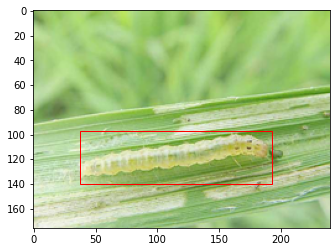

In [130]:
visualise_img(df, 0, img2)